# Energy and Buildings Paper V4

In [1]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime
from ast import literal_eval

In [2]:
#variables - MAKE SURE THESE ARE IDENTICAL TO WHAT WAS USED IN THE MODEL
myNetworks = ['bowling green','long island city','sunnyside','crown heights','grasslands','fresh kills','williamsburg','northeast bronx','ridgewood']

#these are the columns with lists in them
strToList = ['annualPVkWhDC_degraded','annualPVkWhAC_degraded','avoidedGridCosts','maxAutoParticipationMonthlyW_C','maxAutoParticipationMonthlyW_D','maxAutoParticipationW_C','maxAutoParticipationW_D','drIncMonthly_C','drIncMonthly_D','drIncAnnual_C','drIncAnnual_D','drPerformanceIncome','annualIncome']

# Read Data

## Read Model Results

In [3]:
results_df = pd.read_csv('results/results_df_1706440654.csv')

#drop the index if it was saved in the  file
results_df = results_df.drop(columns='Unnamed: 0')
results_df.head()

network  eventStart   az  pvW  batWh  gridChargeTime  dischargeRateW  \
0  bowling green          11  110   40  288.0             2.0            57.6   
1  bowling green          11  110   50  288.0             2.0            57.6   
2  bowling green          11  110   60  288.0             2.0            57.6   
3  bowling green          11  110   70  288.0             2.0            57.6   
4  bowling green          11  110   80  288.0             2.0            57.6   

        capex  dollarPerBatkWh  \
0  512.659713         0.001780   
1  524.635963         0.001822   
2  536.612213         0.001863   
3  548.588463         0.001905   
4  560.564713         0.001946   

                              annualPVkWhDC_degraded  ... minDRkWperf  \
0  [49.15755553736246, 48.66597998198884, 48.1793...  ...    0.312609   
1  [61.44694442170308, 60.83247497748605, 60.2241...  ...    0.306496   
2  [73.73633330604369, 72.99896997298325, 72.2689...  ...    0.300383   
3  [86.02572219038431, 85.16546496848046, 84.3138...  ...    0.294269   
4  [98.31511107472492, 97.33195996397768, 96.3586...  ...    0.288156   

                                        annualIncome     LCOSS    realRoi  \
0  [10.768928186546251, 10.684480331876076, 10.59...  0.031259  52.089332   
1  [13.447050371702087, 13.39253286911642, 13.335...  0.031429  41.117353   
2  [16.125064390756886, 16.10048016363939, 16.074...  0.031598  34.259325   
3  [18.802893024710247, 18.80824843437299, 18.812...  0.031766  29.566896   
4  [21.4805356400861, 21.515834388298778, 21.5503...  0.031932  26.154213   

  Cycles  lifespan workingLife  profitableYears  incomeAfterRoi  iarSplit  
0   3000  8.219178    8.219178              0.0             0.0       0.0  
1   3000  8.219178    8.219178              0.0             0.0       0.0  
2   3000  8.219178    8.219178              0.0             0.0       0.0  
3   3000  8.219178    8.219178              0.0             0.0       0.0  
4   3000  8.219178    8.219178              0.0             0.0       0.0  

[5 rows x 36 columns]

In [4]:
#convert strings to lists
for c in strToList:
    results_df[c] = results_df[c].apply(literal_eval)

In [5]:
#check data types if needed
# for k in list(results_df.keys()):
#     print(k)
#     print(type(results_df.iloc[0][k]))
#     if type(results_df.iloc[0][k]).__name__ == 'list':
#         print(type(results_df.iloc[0][k][0]))
#     print(results_df.iloc[0][k])

## Read in network data

In [6]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2024.csv')

display(networks_df.head())

borough          network start time end time  tier
0   bronx    central bronx      16:00    20:00     2
1   bronx          fordham      16:00    20:00     2
2   bronx  northeast bronx      16:00    20:00     2
3   bronx        riverdale      16:00    20:00     2
4   bronx  southeast bronx      16:00    20:00     2

In [7]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getDLRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getCSRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getDLRPrate(networkName) + getCSRPrate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

# Analyze Results

In [8]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'gridChargeTime',
       'dischargeRateW', 'capex', 'dollarPerBatkWh', 'annualPVkWhDC_degraded',
       'annualPVkWhAC_degraded', 'avoidedGridCosts', 'immediateEventAmt',
       'maxAutoParticipationMonthlyW_C', 'maxAutoParticipationMonthlyW_D',
       'maxAutoParticipationW_C', 'maxAutoParticipationW_D', 'avgMAPw_C',
       'avgMAPw_D', 'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D',
       'drIncAnnual_C', 'drIncAnnual_D', 'drPerformanceIncome', 'minDRinc',
       'minDRkWperf', 'annualIncome', 'LCOSS', 'realRoi', 'Cycles', 'lifespan',
       'workingLife', 'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

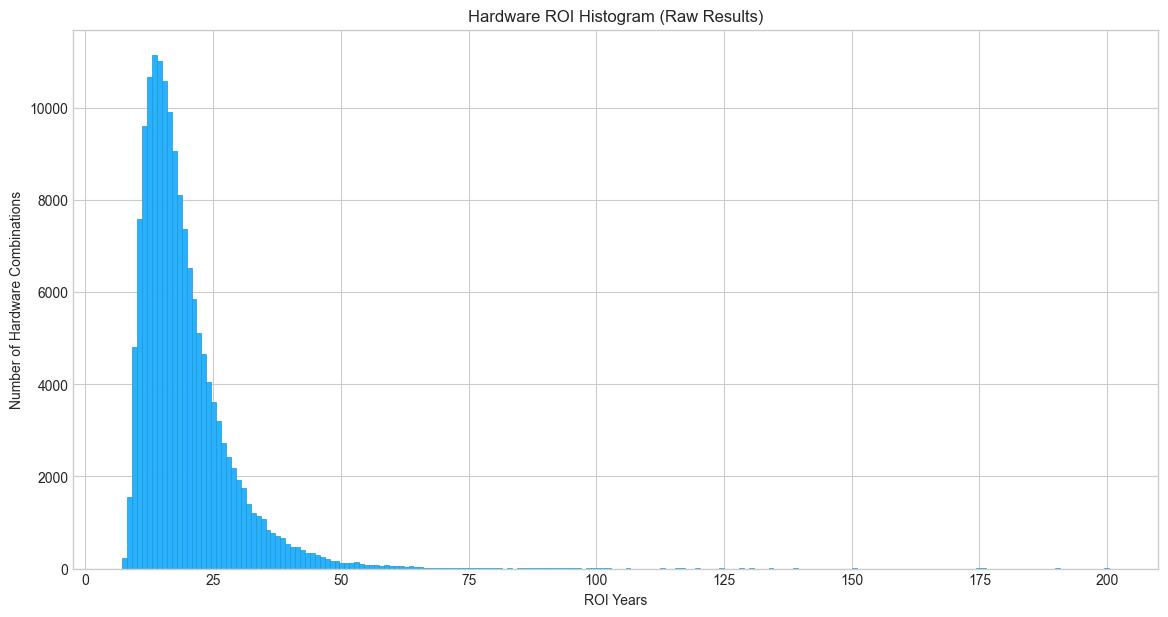

In [9]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering to Favorable ROIs

In [99]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['realRoi'] <= results_df['workingLife']] 

favROI_df_Z = favROI_df[favROI_df['immediateEventAmt'] == 0] 
favROI_df_O = favROI_df[favROI_df['immediateEventAmt'] == 1] 
favROI_df_F = favROI_df[favROI_df['immediateEventAmt'] == 5] 

In [109]:
#get total combinations by azimuth, frequency, and network

print('Total Combinations')
print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
print('')

print('Eastern')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==110].shape[0]/favROI_df_F[favROI_df_F['az']==110].shape[0])) #the closer to 1, the less impactful
print('')

print('Southern')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==180].shape[0]/favROI_df_F[favROI_df_F['az']==180].shape[0])) #the closer to 1, the less impactful
print('')

print('Western')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==250].shape[0]/favROI_df_F[favROI_df_F['az']==250].shape[0])) #the closer to 1, the less impactful


Total Combinations
3536 total favorable ROI hardware combinations generated
1199 total favorable ROI hardware combinations generated - Zero Immediate Event
1189 total favorable ROI hardware combinations generated - One Immediate Event
1148 total favorable ROI hardware combinations generated - Five Immediate Event

Eastern
799 eastern favorable ROI hardware combinations generated
267 eastern favorable ROI hardware combinations generated - Zero Immediate Event
267 eastern favorable ROI hardware combinations generated - One Immediate Event
265 eastern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0075471698113208

Southern
1886 southern favorable ROI hardware combinations generated
640 southern favorable ROI hardware combinations generated - Zero Immediate Event
634 southern favorable ROI hardware combinations generated - One Immediate Event
612 southern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0457516339869282

Wester

In [107]:
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]

    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]
    tempDF_O = tempDF[tempDF['immediateEventAmt'] == 1]
    tempDF_F = tempDF[tempDF['immediateEventAmt'] == 5]

    print('Total Combinations')
    print(str(tempDF.shape[0])+ ' total favorable ROI hardware combinations generated')
    print(str(tempDF_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
    print(str(tempDF_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
    print(str(tempDF_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
    print('Impact: ' + str(tempDF_Z.shape[0]/tempDF_F.shape[0])) #the closer to 1, the less impactful
    
    print('')

Network: bowling green
Total Combinations
752 total favorable ROI hardware combinations generated
253 total favorable ROI hardware combinations generated - Zero Immediate Event
253 total favorable ROI hardware combinations generated - One Immediate Event
246 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0284552845528456

Network: long island city
Total Combinations
447 total favorable ROI hardware combinations generated
150 total favorable ROI hardware combinations generated - Zero Immediate Event
150 total favorable ROI hardware combinations generated - One Immediate Event
147 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0204081632653061

Network: sunnyside
Total Combinations
254 total favorable ROI hardware combinations generated
85 total favorable ROI hardware combinations generated - Zero Immediate Event
85 total favorable ROI hardware combinations generated - One Immediate Event
84 total favorable ROI h

In [137]:
#network combos by azimuth
print("Network combos by azimuth - Zero Immediate Event")
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]
    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]

    for a in [110,180,250]:
        print('Azimuth ' + str(a) + ": " + str(tempDF_Z[tempDF_Z['az']==a].shape[0])+ ' total favorable ROI hardware combinations generated')
    print('')

Network combos by azimuth - Zero Immediate Event
Network: bowling green
Azimuth 110: 64 total favorable ROI hardware combinations generated
Azimuth 180: 125 total favorable ROI hardware combinations generated
Azimuth 250: 64 total favorable ROI hardware combinations generated

Network: long island city
Azimuth 110: 29 total favorable ROI hardware combinations generated
Azimuth 180: 80 total favorable ROI hardware combinations generated
Azimuth 250: 41 total favorable ROI hardware combinations generated

Network: sunnyside
Azimuth 110: 16 total favorable ROI hardware combinations generated
Azimuth 180: 51 total favorable ROI hardware combinations generated
Azimuth 250: 18 total favorable ROI hardware combinations generated

Network: crown heights
Azimuth 110: 12 total favorable ROI hardware combinations generated
Azimuth 180: 42 total favorable ROI hardware combinations generated
Azimuth 250: 9 total favorable ROI hardware combinations generated

Network: grasslands
Azimuth 110: 5 total

In [138]:
#median performance

print('Median DR Performance - Watts')
print('')

print(str(favROI_df['avgMAPw_C'].median())+ ' Median CSRP - Total')
print(str(favROI_df['avgMAPw_D'].median())+ ' Median DRLP - Total')
print(str(favROI_df_Z['avgMAPw_C'].median())+ ' Median CSRP - Zero')
print(str(favROI_df_Z['avgMAPw_D'].median())+ ' Median DRLP - Zero')
print(str(favROI_df_O['avgMAPw_C'].median())+ ' Median CSRP - One')
print(str(favROI_df_O['avgMAPw_D'].median())+ ' Median DRLP - One')
print(str(favROI_df_F['avgMAPw_C'].median())+ ' Median CSRP - Five')
print(str(favROI_df_F['avgMAPw_D'].median())+ ' Median DRLP - Five')

for a in [110,180,250]:
    print('')
    print(str(a) + ' degrees')
    print('DRLP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_D'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Five Immediate Event')
    print('CSRP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_C'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_C'].median())+ ' CRSP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_C'].median())+ ' CRSP - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_C'].median())+ ' CRSP - Five Immediate Event')

Median DR Performance - Watts

252.0728381322892 Median CSRP - Total
160.0174026837821 Median DRLP - Total
254.91211794801785 Median CSRP - Zero
196.1077289442773 Median DRLP - Zero
253.67979194228337 Median CSRP - One
160.0174026837821 Median DRLP - One
250.830119999023 Median CSRP - Five
160.0174026837821 Median DRLP - Five

110 degrees
DRLP
160.0174026837821 DLRP Median Performance - Zero Immediate Event
160.0174026837821 DLRP Median Performance - One Immediate Event
160.0174026837821 DLRP Median Performance - Five Immediate Event
CSRP
206.88029495114648 CRSP Median Performance - Zero Immediate Event
206.88029495114648 CRSP - One Immediate Event
205.809790069584 CRSP - Five Immediate Event

180 degrees
DRLP
196.1077289442773 DLRP Median Performance - Zero Immediate Event
196.1077289442773 DLRP Median Performance - One Immediate Event
196.1077289442773 DLRP Median Performance - Five Immediate Event
CSRP
260.3871655100516 CRSP Median Performance - Zero Immediate Event
260.209180238630

In [92]:
#ROI data

#arg: results DF
def snapShot(rDF):
    
    #lifespan
    print("Min Lifespan: " + str(min(rDF['lifespan'])))
    print("Mean Lifespan: " + str(rDF['lifespan'].mean()))
    print("Median Lifespan: " + str(rDF['lifespan'].median()))
    print("Max Lifespan: " + str(max(rDF['lifespan'])))
    print('')

    #working life
    print("Min working life: " + str(min(rDF['workingLife'])))
    print("Mean working life: " + str(rDF['workingLife'].mean()))
    print("Median working life: " + str(rDF['workingLife'].median()))
    print("Max working life: " + str(max(rDF['workingLife'])))
    print('')
    
    # fastest ROI
    fARoi = rDF[rDF['realRoi'] == min(rDF['realRoi'])]
    print("Fastest ROI: " + str(fARoi['realRoi'].iloc[0]) + "yrs")

    mARoi = allROI['realRoi'].mean()
    print("Mean ROI: " + str(mARoi))
    
    print("Median ROI: " + str(allROI['realRoi'].median()))
    # slowest ROI
    sARoi = rDF[rDF['realRoi'] == max(rDF['realRoi'])]
    print("Slowest ROI: " + str(sARoi['realRoi'].iloc[0]) + "yrs")

    print('')

    # Income After ROI
    maxAIAR = rDF[rDF['incomeAfterRoi'] == max(rDF['incomeAfterRoi'])]
    print("Greatest IAR: $" + str(maxAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxAIAR['lifespan'].iloc[0])) +' years)')

    mAIRoi = rDF['incomeAfterRoi'].mean()
    print("Mean IROI: " + str(mAIRoi))

    print("Median IROI: " + str(rDF['incomeAfterRoi'].median()))
    
    minAIAR = rDF[rDF['incomeAfterRoi'] == min(rDF['incomeAfterRoi'])]
    print("Lowest IAR: $" + str(minAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,minAIAR['lifespan'].iloc[0])) +' years)')

    print('')
    
    # Income After ROI Split
    print("Greatest IAR Split: $" + str(max(rDF['iarSplit'])))

    print("Mean IAR Split: " + str(rDF['iarSplit'].mean()))
    print("Median IAR Split: " + str(rDF['iarSplit'].median()))

    print("Lowest IAR Split: $" + str(min(rDF['iarSplit'])))

    print('')
    
    #min PV
    md = rDF[rDF['pvW'] == min(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum PV Arrays: ")
    print(set(a))
    
    #max PV
    md = rDF[rDF['pvW'] == max(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum PV Arrays: ")
    print(set(a))  
    
    print("mean PV: " + str(rDF['pvW'].mean()))
    print("median PV: " + str(rDF['pvW'].median()))

    print('')

    #min BAT
    md = rDF[rDF['batWh'] == min(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum Bat Wh: ")
    print(set(a))
    
    #max BAT
    md = rDF[rDF['batWh'] == max(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum Bat Wh: ")
    print(set(a))  

    print("mean Bat Wh: " + str(rDF['batWh'].mean()))
    print("median Bat Wh: " + str(rDF['batWh'].median()))

    print('')

    #CSRP performance
    print("Min CSRP W Performance: " + str(round(min(rDF['avgMAPw_C']),2)))
    print("Mean CSRP W Performance: " + str(round(rDF['avgMAPw_C'].mean(),2)))
    print("Median CSRP W Performance: " + str(round(rDF['avgMAPw_C'].median(),2)))
    print("Max CSRP W Performance: " + str(round(max(rDF['avgMAPw_C']),2)))

    print('')

    #DLRP performance
    print("Min DLRP W Performance: " + str(round(min(rDF['avgMAPw_D']),2)))
    print("Mean DLRP W Performance: " + str(round(rDF['avgMAPw_D'].mean(),2)))
    print("Median DLRP W Performance: " + str(round(rDF['avgMAPw_D'].median(),2)))
    print("Max DLRP W Performance: " + str(round(max(rDF['avgMAPw_D']),2)))
    
    
snapShot(favROI_df)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.686667079898346
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.607171635777599
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.25yrs
Mean ROI: 9.06721342383107
Median ROI: 9.25
Slowest ROI: 10.0yrs

Greatest IAR: $435.1103631811656 ($45.37579501746442/per year for 9.58904109589041 years)
Mean IROI: 85.87810737164756
Median IROI: 69.25147962340864
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $45.37579501746442
Mean IAR Split: 8.949110258931254
Median IAR Split: 7.221940017869759
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 960.0]', '[260, 614.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 1440.0]', '[500, 2000.0]', '[500, 2232.0]', '[500, 1920.0]', '[500, 1152.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 680.96]'}
mean PV: 423.9762443438914
median PV: 430.0

Combinations with Minimum Ba

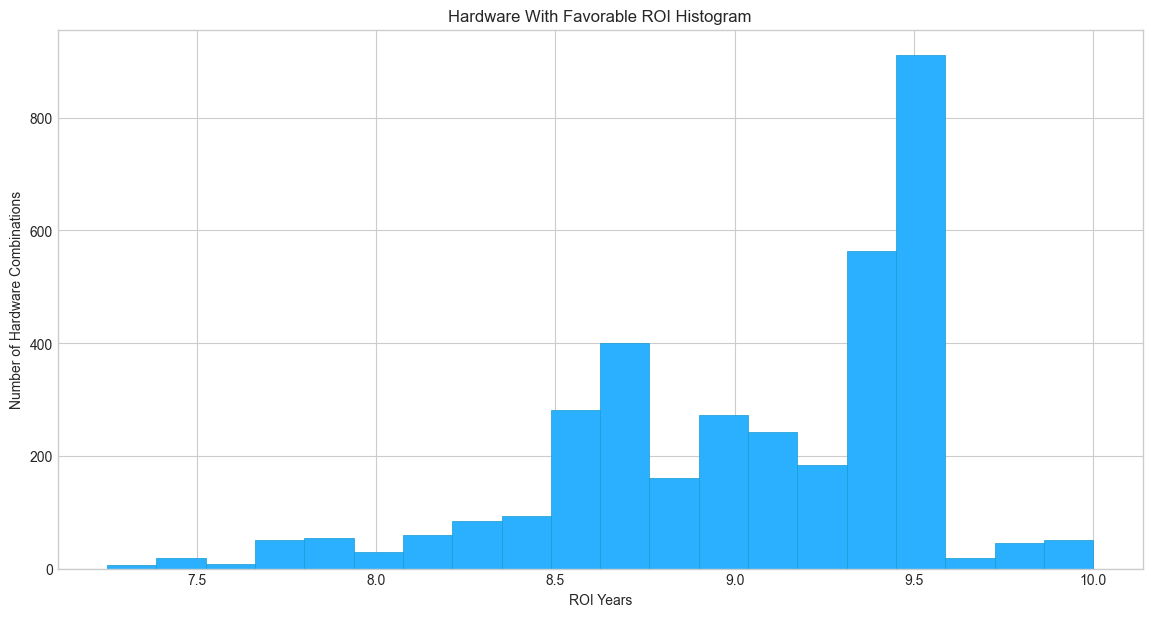

In [53]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['realRoi'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


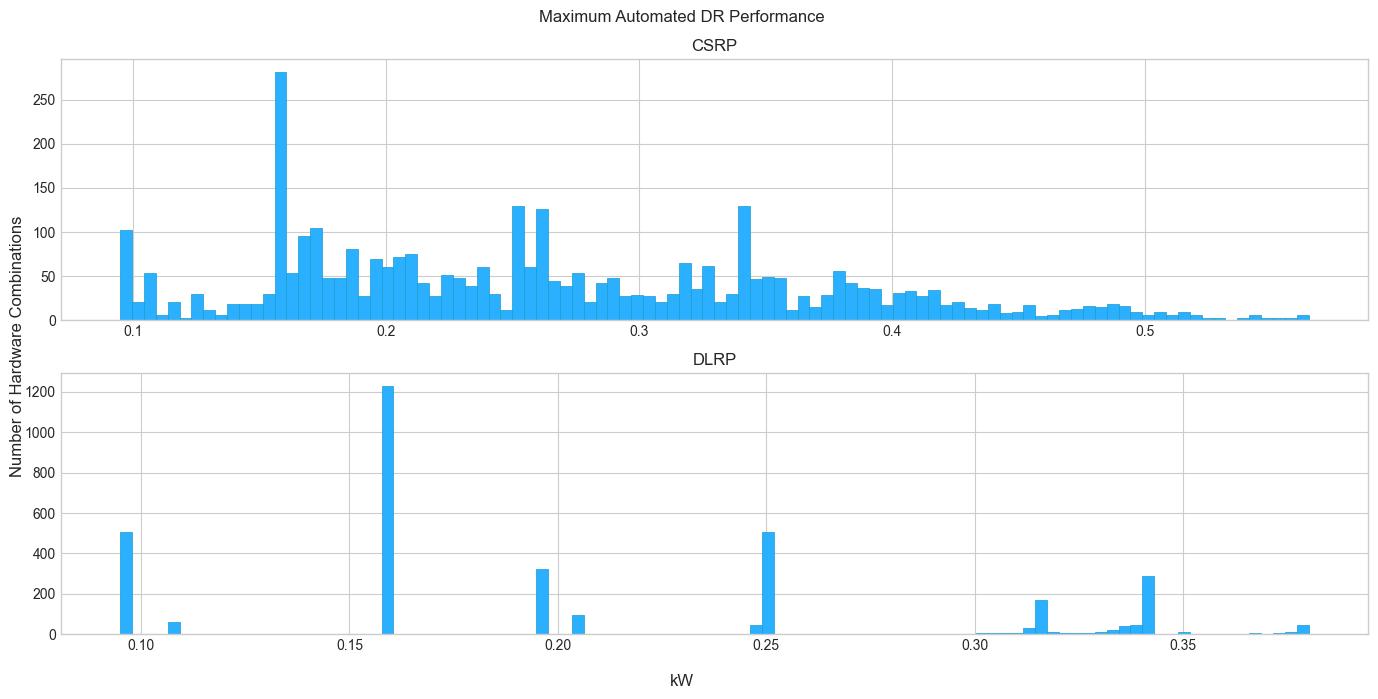

In [54]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(14, 7))
fig.suptitle('Maximum Automated DR Performance') 

ax1.hist(favROI_df['avgMAPw_C'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax1.set_title("CSRP")
ax2.hist(favROI_df['avgMAPw_D'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax2.set_title("DLRP")

#ax1.set(xlabel='kW',ylabel="Number of Hardware Combinations")
#ax2.set(xlabel='kW',ylabel="Number of Hardware Combinations")

fig.supxlabel('kW')
fig.supylabel('Number of Hardware Combinations')

#fig.set(ylabel='Number of Hardware Combinations')

fig.subplots_adjust(bottom=0, top=1.5)

fig.tight_layout(pad=1.0)
#fig.style.use('seaborn-whitegrid') # nice and clean grid
#ax1.xlabel('Max Auto kW') 
fig.show()


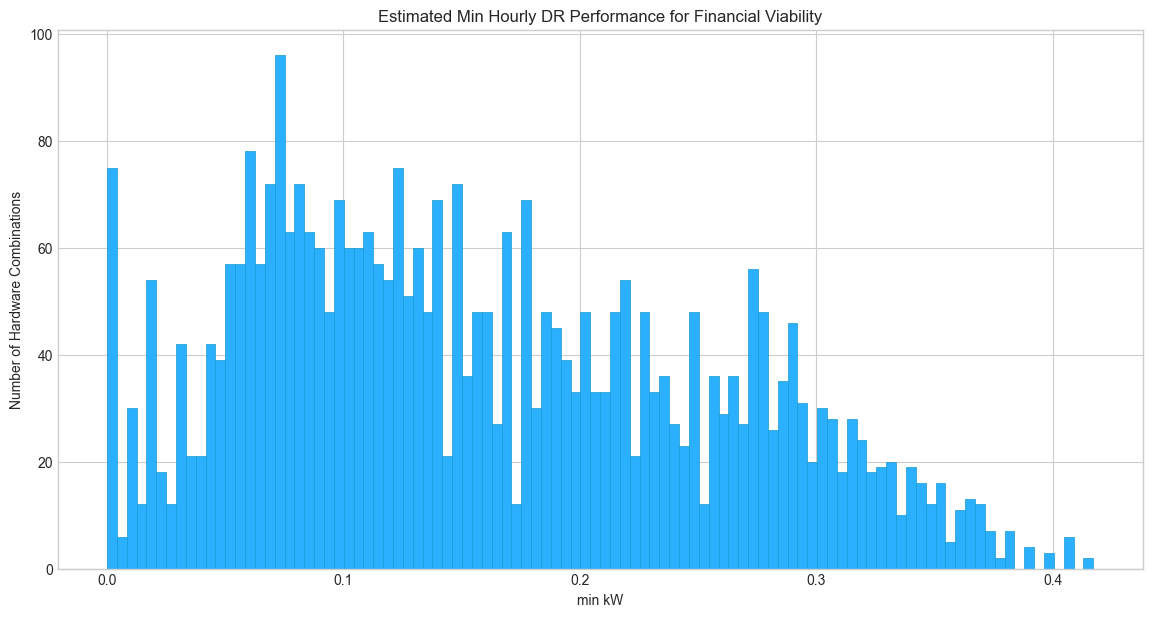

In [55]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['minDRkWperf'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Estimated Min Hourly DR Performance for Financial Viability') 
plt.xlabel('min kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware Combinations'}, xlabel='Battery Wh', ylabel='PV Array W'>

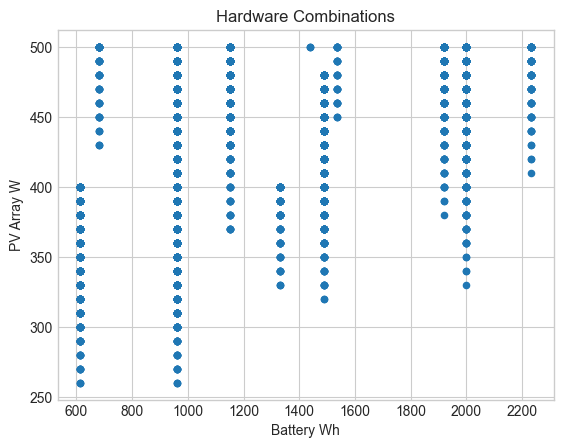

In [59]:
#hardare combos
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW',title='Hardware Combinations',xlabel="Battery Wh",ylabel="PV Array W")


# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall - Zero Immediate Events

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [110]:
snapShot(favROI_df_F)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.68927497494153
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.607655959142761
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.25yrs
Mean ROI: 9.06721342383107
Median ROI: 9.25
Slowest ROI: 10.0yrs

Greatest IAR: $435.1103631811656 ($45.37579501746442/per year for 9.58904109589041 years)
Mean IROI: 86.55006635421776
Median IROI: 70.38358783345848
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $45.37579501746442
Mean IAR Split: 9.019005680904511
Median IAR Split: 7.340002731203526
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[260, 960.0]', '[260, 614.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 1440.0]', '[500, 2000.0]', '[500, 2232.0]', '[500, 1920.0]', '[500, 1152.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 680.96]'}
mean PV: 424.1463414634146
median PV: 430.0

Combinations with Minimum Bat

In [111]:
# fastest ROI
fRoi = favROI_df_Z[favROI_df_Z['realRoi'] == min(favROI_df_Z['realRoi'])]
print("Fastest ROI: " + str(fRoi['realRoi'].iloc[0]) + "yrs")
# slowest ROI
sRoi = favROI_df_Z[favROI_df_Z['realRoi'] == max(favROI_df_Z['realRoi'])]
print("Slowest ROI: " + str(sRoi['realRoi'].iloc[0]) + "yrs")


Fastest ROI: 7.25yrs
Slowest ROI: 10.0yrs


Greatest IAR: $435.1103631811656 ($45.37579501746442/per year for 9.58904109589041 years)
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)
Amount with 0 IAR: 165


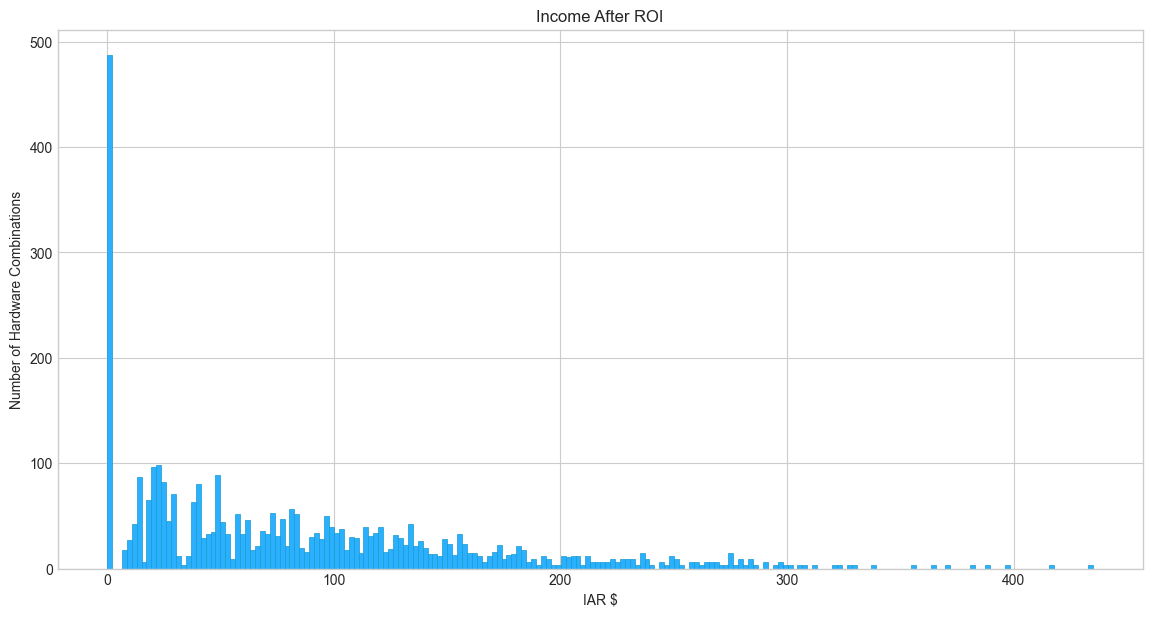

In [115]:
# Income After ROI
maxIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == max(favROI_df_Z['incomeAfterRoi'])]
print("Greatest IAR: $" + str(maxIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

minIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == min(favROI_df_Z['incomeAfterRoi'])]
print("Lowest IAR: $" + str(minIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

print('Amount with 0 IAR: ' + str(favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware'}, xlabel='batWh', ylabel='pvW'>

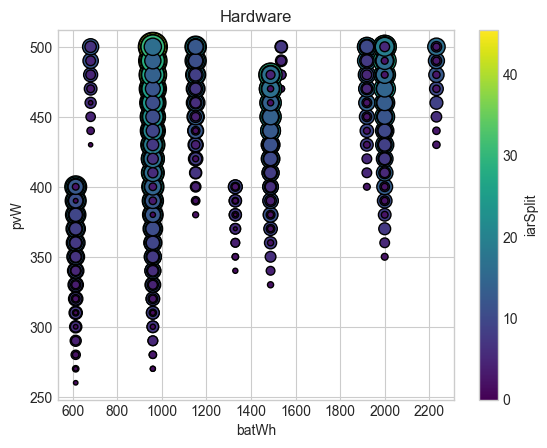

In [116]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware')


<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

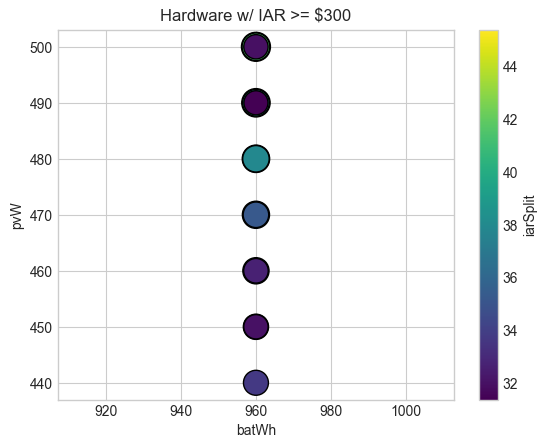

In [117]:
# High IAR

highIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


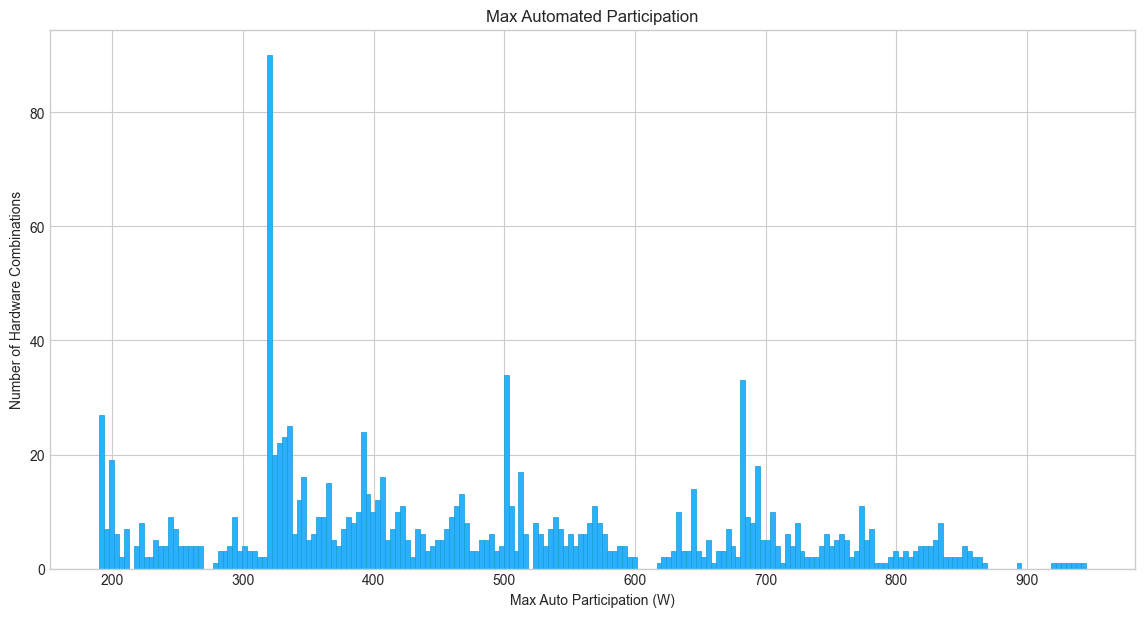

In [118]:
favROI_df_Z['avgMAPw'] = favROI_df_Z['avgMAPw_C'] + favROI_df_Z['avgMAPw_D']

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['avgMAPw'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Max Automated Participation') 
plt.xlabel('Max Auto Participation (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

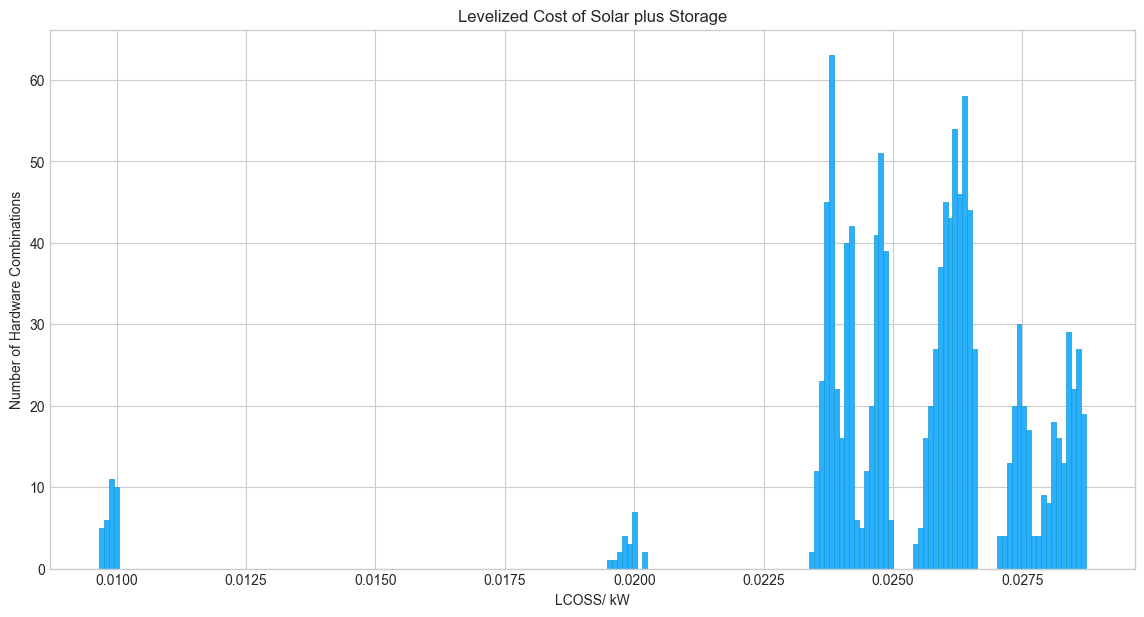

In [119]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['LCOSS'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('LCOSS/ kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [120]:
#levelized cost compaprison
#https://www.statista.com/statistics/493797/estimated-levelized-cost-of-energy-generation-in-the-us-by-technology/
#2023 commercial solar + store lcoe: $46-102/ per megawatts

print(46/1000)
print(102/1000)

0.046
0.102


## Impact of Network Characteristics

Below this point, only favorable ROI combinations are considered.

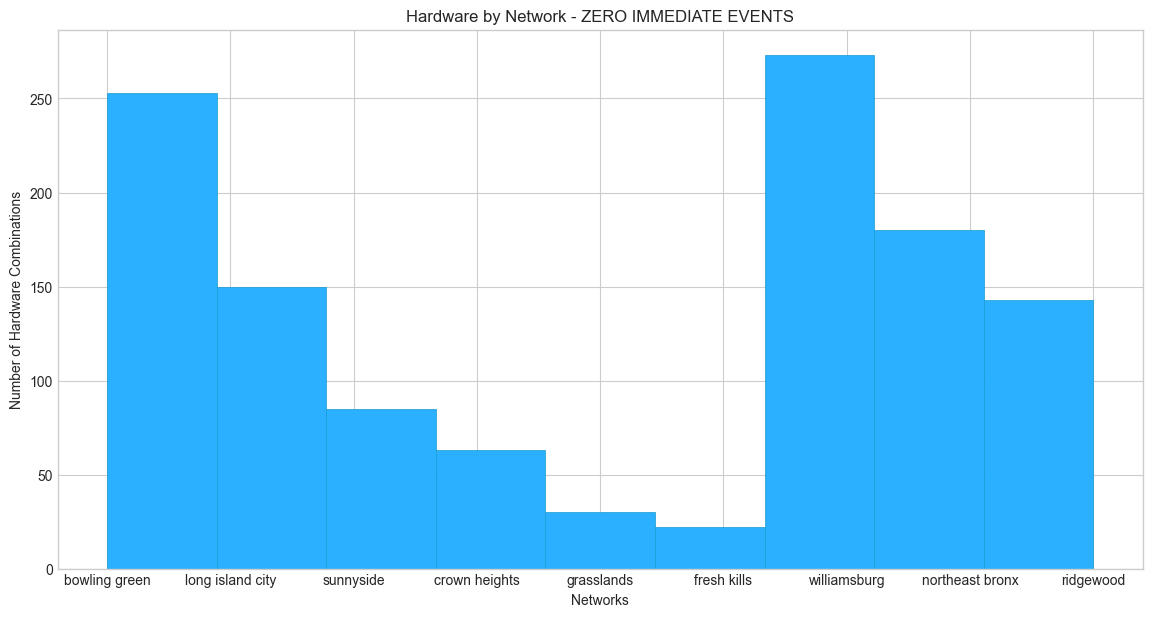

In [121]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware by Network - ZERO IMMEDIATE EVENTS') 
plt.xlabel('Networks') 
#plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [122]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_O['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - ONE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

In [123]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_F['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - FIVE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

<AxesSubplot:title={'center':'ROIs'}, xlabel='realRoi', ylabel='eventStart'>

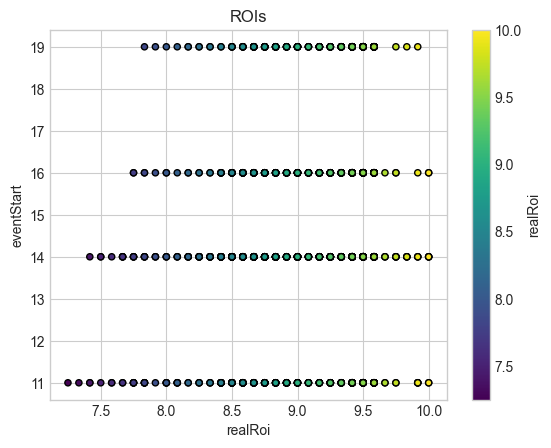

In [124]:
favROI_df_Z.plot(kind = 'scatter', x = 'realRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='ROIs')


In [125]:
#build a data frame with characteristics by neighborhood

#regardless of azimuth
nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "min capex":[],
    "max capex":[],
    #avg capex is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg capex":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df_Z[favROI_df_Z['network'] == n]
    tN = tNAz#[tNAz['az'] == 180] #uncomment to filter by azimuth
    nFavorable['name'].append(n)
    
    nFavorable['start time'].append(getStartTime(n))
    nFavorable['dr rate $'].append(getTotalRate(n))
    
    if tN.shape[0] != 0:
        nFavorable['total amount'].append(tN.shape[0])
    
        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['min capex'].append(min(tN['capex']))
        nFavorable['max capex'].append(max(tN['capex']))
        nFavorable['avg capex'].append(tN['capex'].mean())
        nFavorable['min ROI'].append(min(tN['realRoi']))
        nFavorable['max ROI'].append(max(tN['realRoi']))
        nFavorable['avg ROI'].append(tN['realRoi'].mean())
        
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        mDR = []
        for y in range(len(tN['maxAutoParticipationW_C'])):
            print(list(tN['maxAutoParticipationW_C']))
            yC = sum(list(tN['maxAutoParticipationW_C'])[y])
            yD = sum(list(tN['maxAutoParticipationW_D'])[y])
            mDR.append(sum([yC,yD])/len(list(tN['maxAutoParticipationW_C'])[y]))

        nFavorable['min DR'].append(min(mDR))
        nFavorable['max DR'].append(max(mDR))
        nFavorable['avg DR'].append(sum(mDR)/len(mDR))
    else:
        for k in ['total amount','min PV','min PV bat Wh','max PV','max PV bat Wh',
                  'min bat','min bat PV W','max bat','max bat PV W',
                  'min capex','max capex','avg capex','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
networkResults_df

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783, 94.93909180434783], [94.93909180434783, 94.93909180434783, 

name  total amount  start time  dr rate $  min PV  \
0     bowling green           253          11         36     260   
1  long island city           150          14         36     290   
2         sunnyside            85          16         36     320   
3     crown heights            63          19         36     330   
4        grasslands            30          14         24     350   
5       fresh kills            22          16         24     370   
6      williamsburg           273          14         43     260   
7   northeast bronx           180          16         43     290   
8         ridgewood           143          19         43     300   

    min PV bat Wh  max PV                                      max PV bat Wh  \
0         [614.0]     500  [1536.0, 1152.0, 1920.0, 1440.0, 960.0, 680.96...   
1         [614.0]     500    [1152.0, 1920.0, 960.0, 680.96, 2000.0, 2232.0]   
2         [614.0]     500                    [1920.0, 2000.0, 1152.0, 960.0]   
3         [614.0]     500                            [1152.0, 2000.0, 960.0]   
4         [614.0]     500                                            [960.0]   
5         [614.0]     500                                            [960.0]   
6         [960.0]     500  [1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0...   
7  [960.0, 614.0]     500  [1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0...   
8         [960.0]     500            [1920.0, 1152.0, 960.0, 2000.0, 2232.0]   

   min bat                                       min bat PV W  ...  \
0    614.0  [320, 290, 260, 390, 360, 330, 300, 270, 400, ...  ...   
1    614.0  [320, 290, 390, 360, 330, 300, 400, 370, 340, ...  ...   
2    614.0      [320, 390, 360, 330, 400, 370, 340, 380, 350]  ...   
3    614.0           [390, 360, 330, 400, 370, 340, 380, 350]  ...   
4    614.0                     [390, 360, 400, 370, 380, 350]  ...   
5    614.0                               [400, 370, 380, 390]  ...   
6    614.0  [320, 290, 390, 360, 330, 300, 270, 400, 370, ...  ...   
7    614.0  [320, 290, 390, 360, 330, 300, 400, 370, 340, ...  ...   
8    614.0  [320, 390, 360, 330, 400, 370, 340, 310, 380, ...  ...   

     avg capex   min ROI    max ROI   avg ROI  min IAR     max IAR  \
0  1349.965927  7.250000  10.000000  8.957181      0.0  435.110363   
1  1300.196137  7.666667   9.916667  9.062778      0.0  326.575165   
2  1249.447579  8.000000   9.583333  9.130392      0.0  264.277926   
3  1246.334696  8.166667   9.583333  9.165344      0.0  237.113273   
4  1149.658304  8.500000   9.583333  9.211111      0.0  173.302182   
5  1163.805456  8.583333   9.583333  9.253788      0.0  155.304408   
6  1385.108003  7.416667  10.000000  9.026252      0.0  396.694269   
7  1359.200339  7.750000  10.000000  9.128704      0.0  306.294898   
8  1349.456365  7.833333   9.916667  9.159091      0.0  290.456955   

      avg IAR      min DR      max DR      avg DR  
0  105.930125  277.699824  945.058441  570.185693  
1   83.705409  219.571570  835.335620  462.235180  
2   69.524017  193.975179  696.112586  378.425523  
3   64.448219  189.878184  682.131706  360.689924  
4   54.657485  243.050252  424.139291  363.396599  
5   48.620862  200.490747  348.016923  310.334097  
6   97.262415  217.514956  857.842397  518.417544  
7   77.172020  193.611723  773.430924  455.409346  
8   70.385138  189.878184  760.394485  438.424278  

[9 rows x 24 columns]

In [126]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'gridChargeTime',
       'dischargeRateW', 'capex', 'dollarPerBatkWh', 'annualPVkWhDC_degraded',
       'annualPVkWhAC_degraded', 'avoidedGridCosts', 'immediateEventAmt',
       'maxAutoParticipationMonthlyW_C', 'maxAutoParticipationMonthlyW_D',
       'maxAutoParticipationW_C', 'maxAutoParticipationW_D', 'avgMAPw_C',
       'avgMAPw_D', 'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D',
       'drIncAnnual_C', 'drIncAnnual_D', 'drPerformanceIncome', 'minDRinc',
       'minDRkWperf', 'annualIncome', 'LCOSS', 'realRoi', 'Cycles', 'lifespan',
       'workingLife', 'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [127]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

# bPD = favROI_df[favROI_df['az'] == 250]
    
# boxPlotData = {}
# for n in myNetworks:
#     bP = bPD[bPD['network'] == n]
#     #print(bP['maxAutoParticipationW'].head())
#     #the full label thing doesn't work when some results are 0
#     #print(type(list(bP['maxAutoParticipationW'])))
#     boxPlotData[n]=bP['maxAutoParticipationW']# + "\n("+ str(bP.iloc[0]['eventStart']) + ", $" + str(bP.iloc[0]['totalDRratekW']) +")"]=bP['maxAutoParticipationW']

# boxPlot_df = pd.DataFrame.from_dict(boxPlotData)
# boxPlot_df.boxplot(figsize=(14,7))

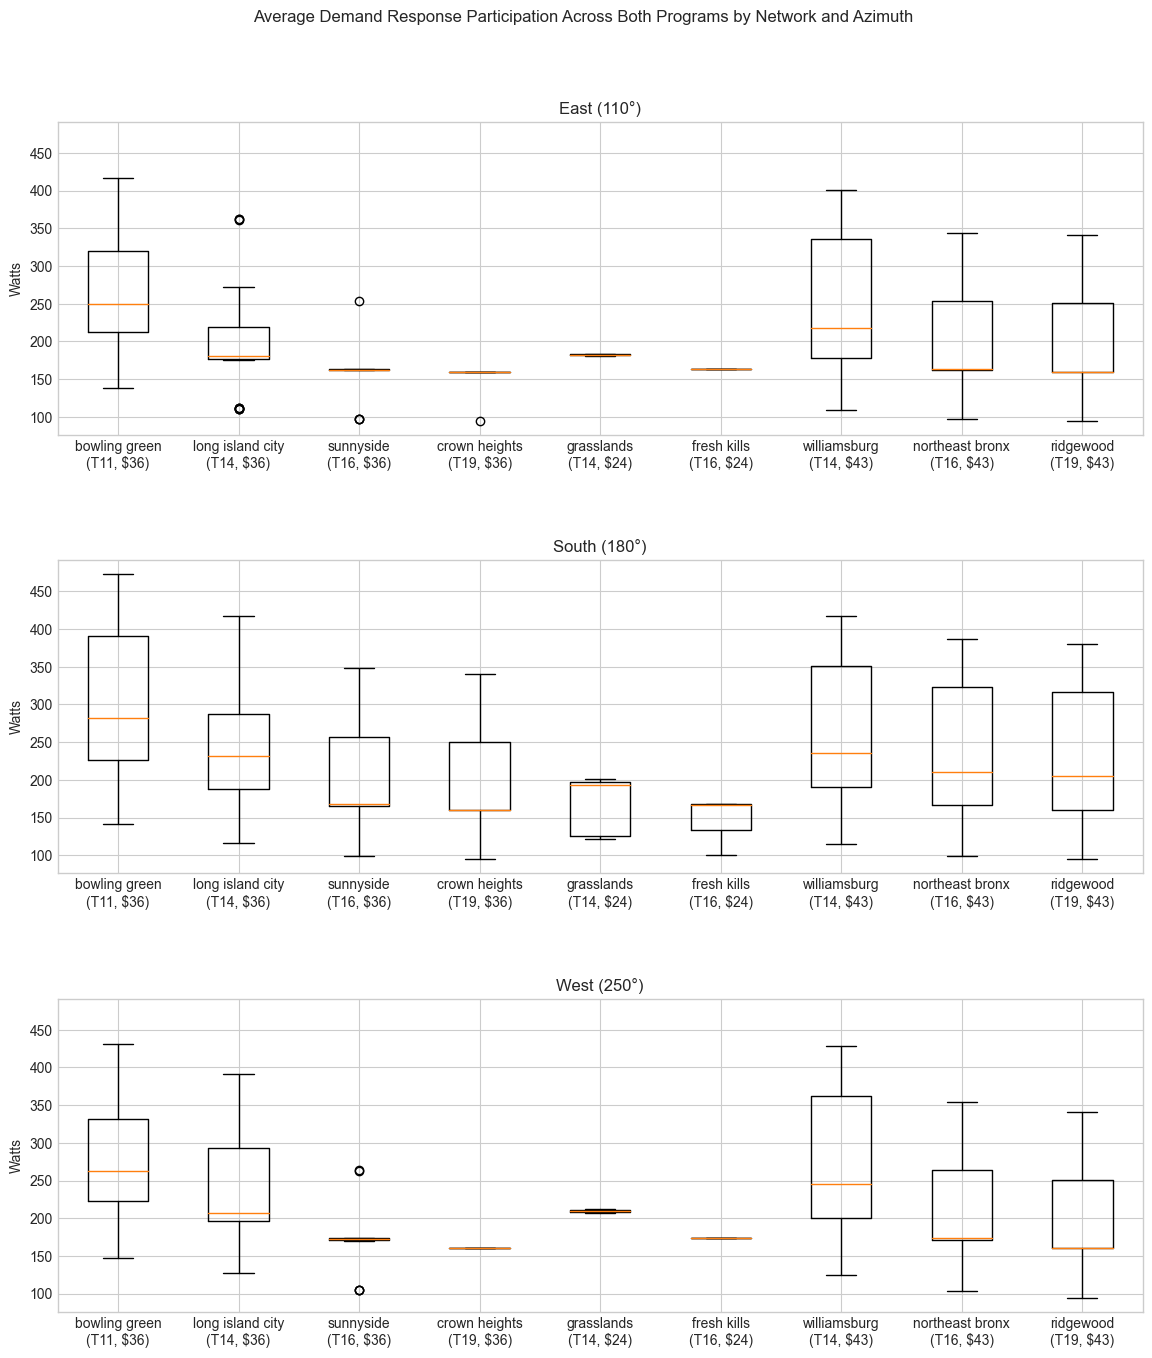

In [131]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list((bP['avgMAPw_C'] + bP['avgMAPw_D']) * .5))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Average Demand Response Participation Across Both Programs by Network and Azimuth')
    
plt.show()

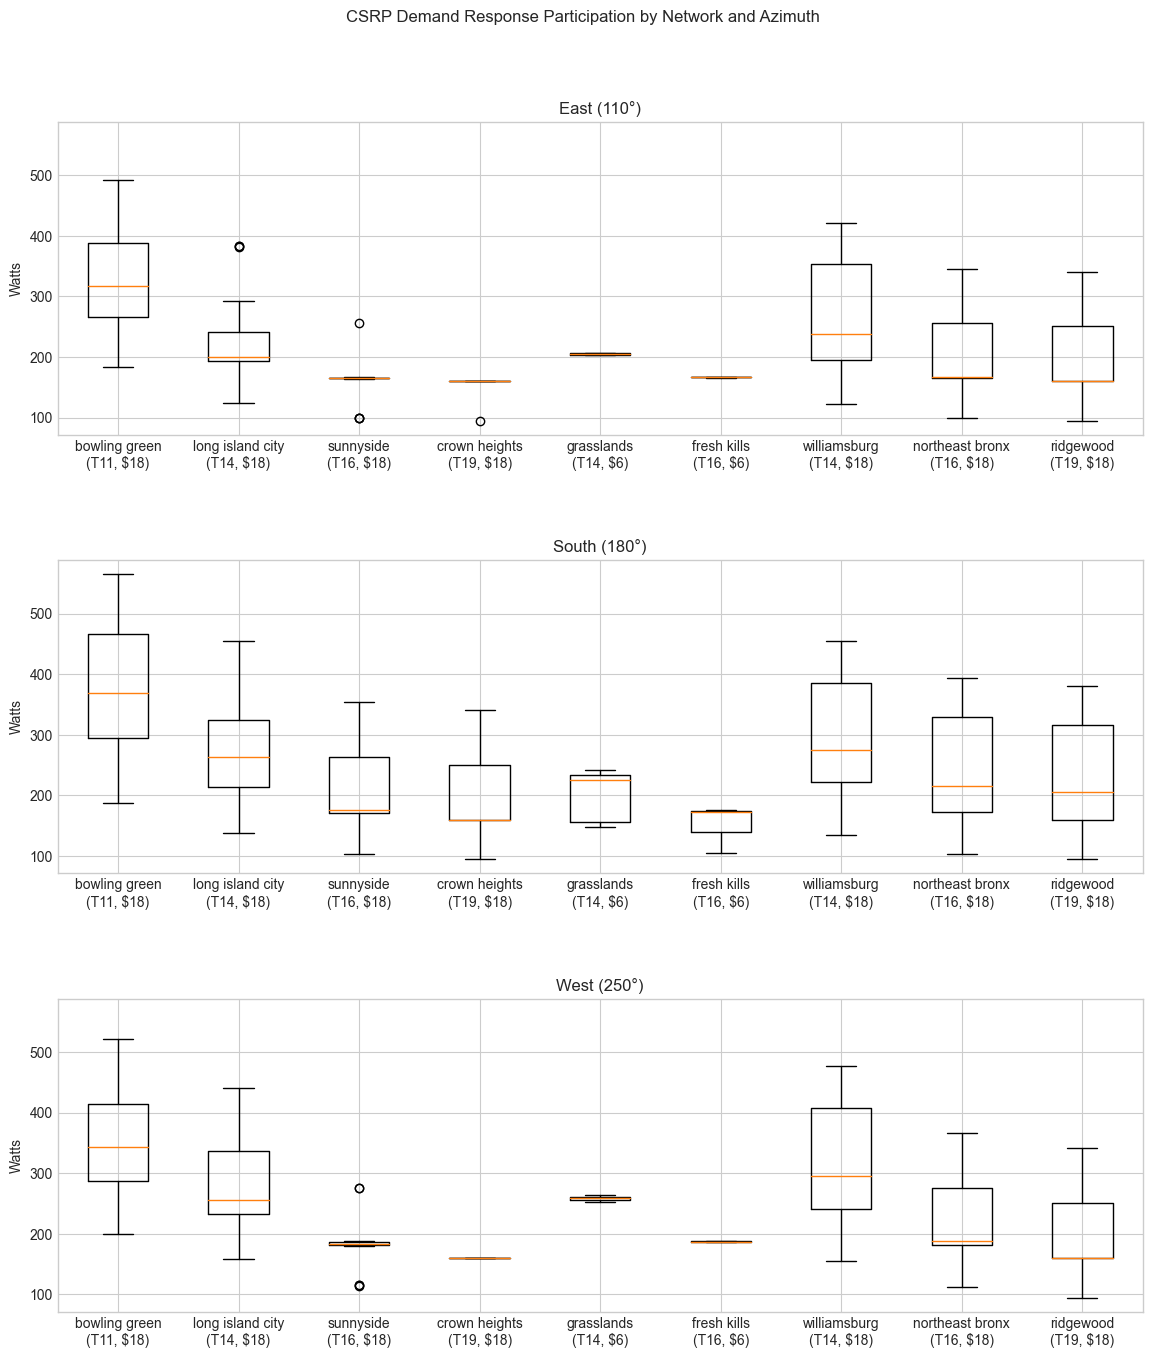

In [129]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getCSRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_C']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('CSRP Demand Response Participation by Network and Azimuth')
    
plt.show()


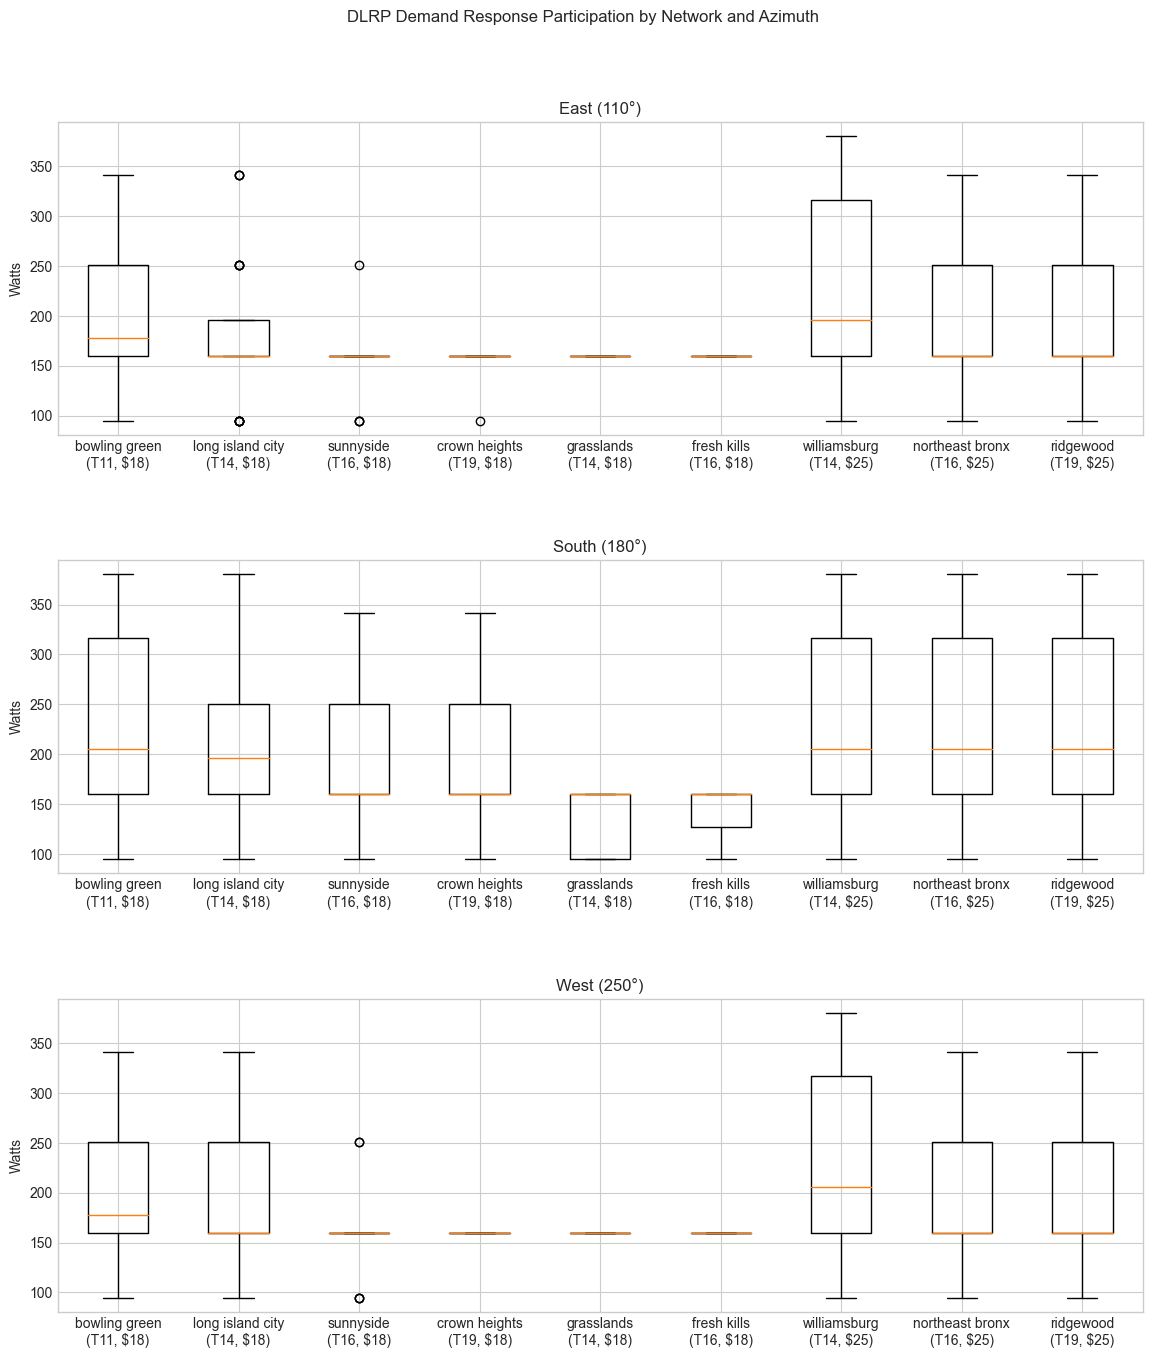

In [130]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getDLRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_D']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Demand Response Participation by Network and Azimuth')
    
plt.show()


<AxesSubplot:title={'center':'Max Auto Participation CSRP'}, xlabel='avgMAPw_C', ylabel='eventStart'>

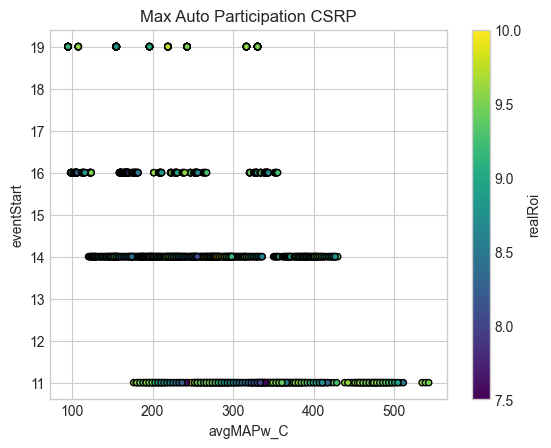

In [203]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_C', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation CSRP')


<AxesSubplot:title={'center':'Max Auto Participation DLRP'}, xlabel='avgMAPw_D', ylabel='eventStart'>

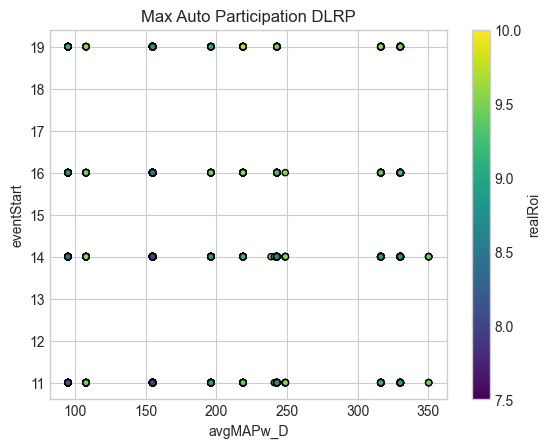

In [204]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_D', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation DLRP')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

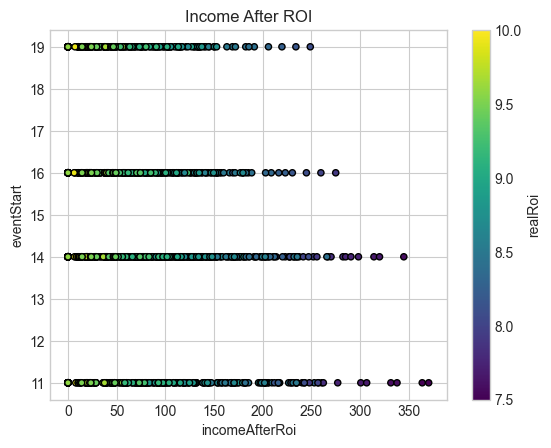

In [205]:
favROI_df_Z.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

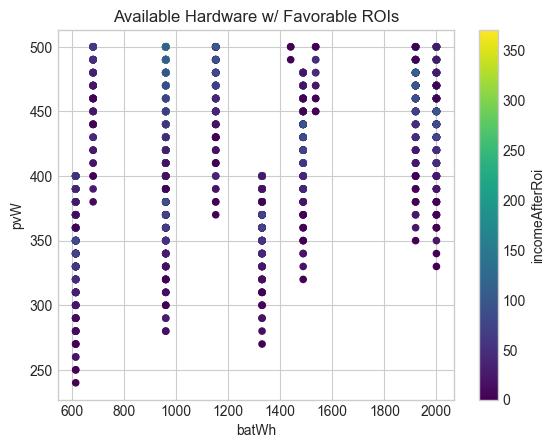

In [206]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs & high IAR'}, xlabel='batWh', ylabel='pvW'>

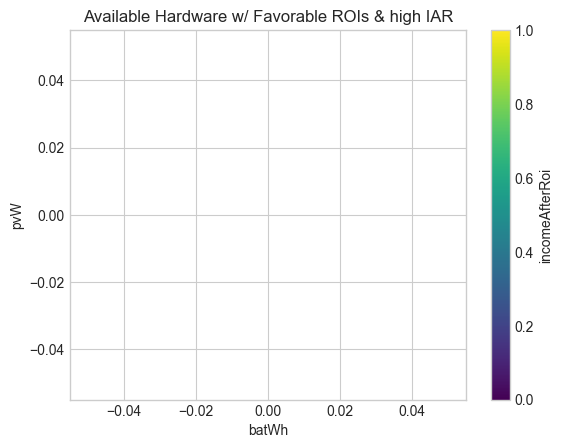

In [207]:
favROI_df_Z[favROI_df_Z['incomeAfterRoi']>=400].plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs & high IAR')


<AxesSubplot:title={'center':'Relationship between IAR and CSRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_C'>

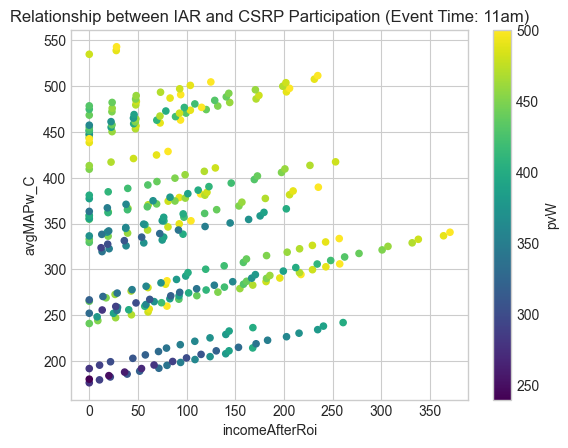

In [208]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_C', c='pvW',colormap='viridis', title='Relationship between IAR and CSRP Participation (Event Time: 11am)')


<AxesSubplot:title={'center':'Relationship between IAR and DLRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_D'>

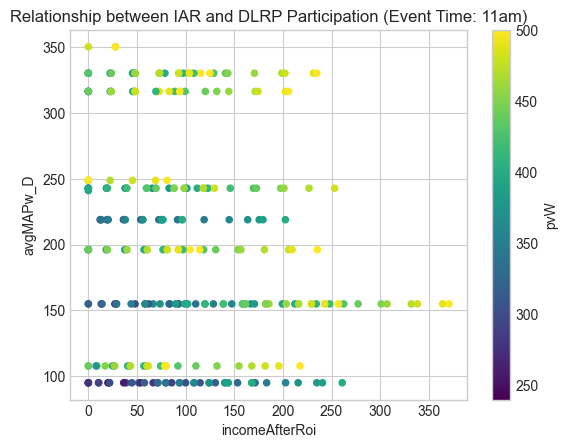

In [209]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_D', c='pvW',colormap='viridis', title='Relationship between IAR and DLRP Participation (Event Time: 11am)')


In [210]:
highParticipation_df = favROI_df_Z[favROI_df_Z['avgMAPw_C']>=400]
highParticipation_df.shape[0]

118

<AxesSubplot:title={'center':'Max Auto CSRP Participation > 400W'}, xlabel='avgMAPw', ylabel='eventStart'>

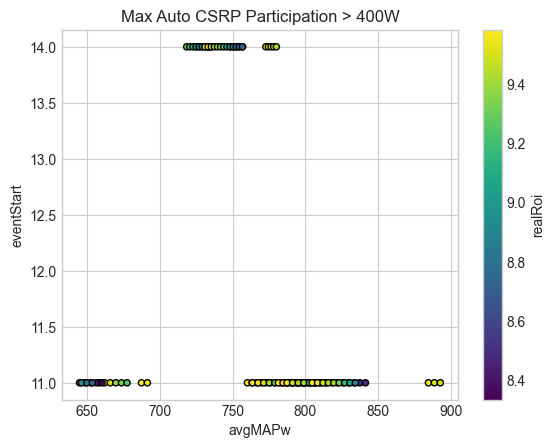

In [211]:
highParticipation_df.plot(kind = 'scatter', x = 'avgMAPw', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto CSRP Participation > 400W')


<AxesSubplot:title={'center':'Available Hardware w/ CSRP Impact > 400W'}, xlabel='batWh', ylabel='pvW'>

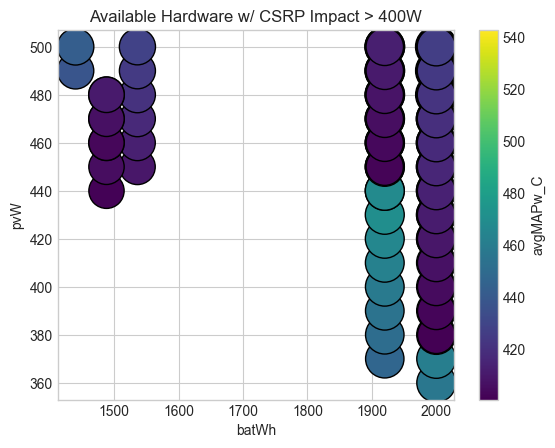

In [212]:
highParticipation_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='avgMAPw_C',s='avgMAPw',edgecolor='black',colormap='viridis', title='Available Hardware w/ CSRP Impact > 400W')


## Impact of Immediate Events

## Loads


### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

### 4 hour rates

In [213]:
favROI_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'gridChargeTime',
       'dischargeRateW', 'capex', 'dollarPerBatkWh', 'annualPVkWhDC_degraded',
       'annualPVkWhAC_degraded', 'avoidedGridCosts', 'immediateEventAmt',
       'maxAutoParticipationMonthlyW_C', 'maxAutoParticipationMonthlyW_D',
       'maxAutoParticipationW_C', 'maxAutoParticipationW_D', 'avgMAPw_C',
       'avgMAPw_D', 'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D',
       'drIncAnnual_C', 'drIncAnnual_D', 'drPerformanceIncome', 'minDRinc',
       'minDRkWperf', 'annualIncome', 'LCOSS', 'realRoi', 'Cycles', 'lifespan',
       'workingLife', 'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

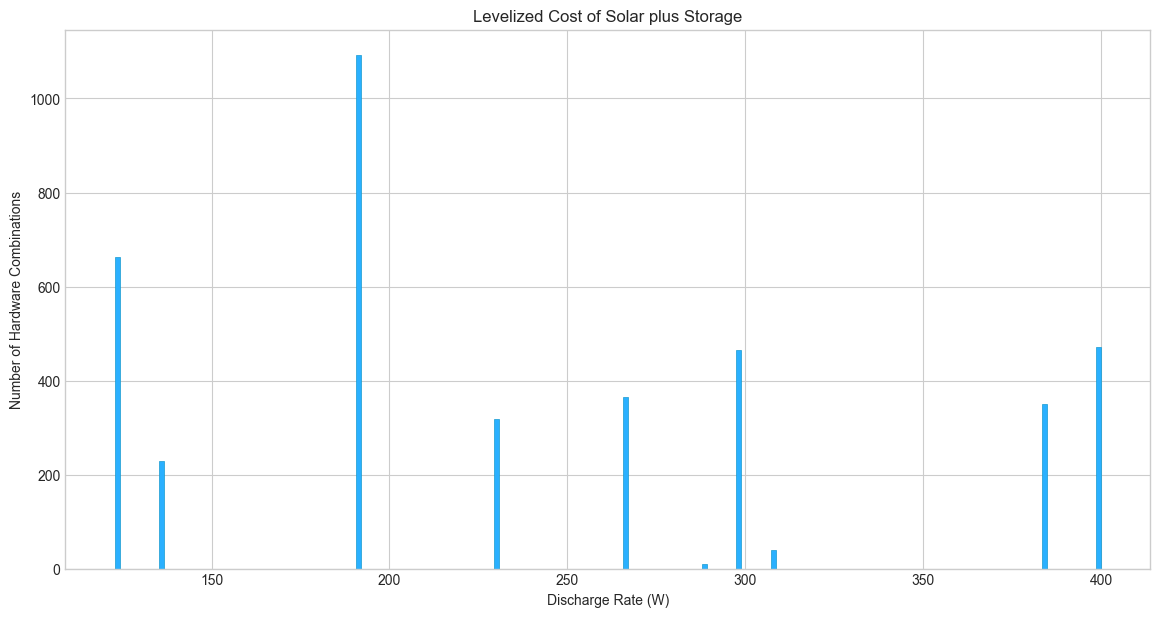

In [214]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['dischargeRateW'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('Discharge Rate (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [215]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle
print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')


Fridge Watts
Max: 266.40000000000003W (6393.6 Wh/day)
Min: 99.9W (2397.6000000000004 Wh/day)


## Final Analysis

Compare to Nest thermostat